In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten,Dropout,Permute
from tensorflow.keras.layers import Conv1D,Conv2D,BatchNormalization,MaxPooling1D,MaxPooling2D,Reshape,LSTM,TimeDistributed
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import pywt
from scipy import signal
from scipy import fft

In [2]:
# Use GPU

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
## Loading and visualizing the data

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


# plt.plot(np.arange(1000),avg_ch_data_class_0)
# plt.plot(np.arange(1000),avg_ch_data_class_1)
# plt.plot(np.arange(1000),avg_ch_data_class_2)
# plt.plot(np.arange(1000),avg_ch_data_class_3)
# plt.axvline(x=500, label='line at t=500',c='cyan')

# plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])


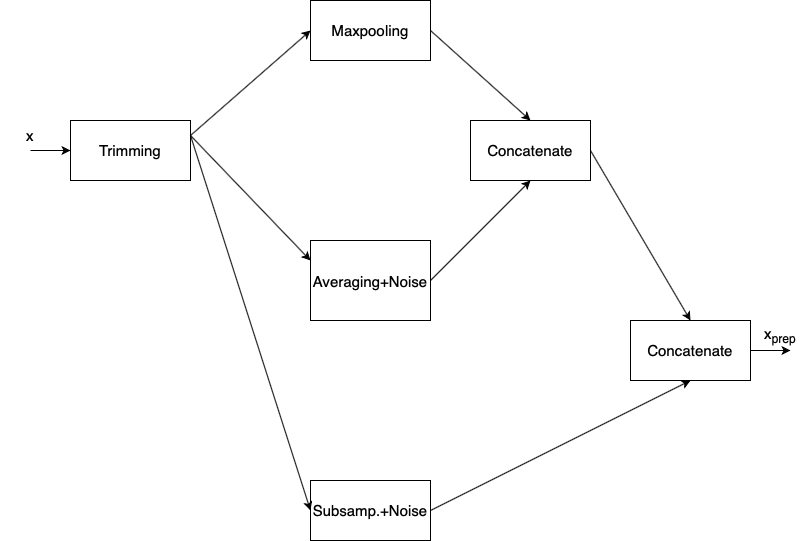

In [4]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
#     print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
#     print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
#     print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
#     print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


# X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)


In [5]:
def data_prep_sliding(X,y):
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    
    total_X = []
    for i in range(X.shape[0]):
        for j in range(10):
          total_X.append(X[i,:,j:j+490])

    total_y = []
    for i in range(y.shape[0]):
        for j in range(10):
          total_y.append(y[i])

    return total_X,total_y

In [6]:
# WPD related
def wpd(X, y):
    isTrmmingEnable = 1
    isLowpassFilteringEnable = 1
    isWPDEnable = 1
    WPDLevel = 3

    if isTrmmingEnable:
      X = X[:,:,0:500]
    
    if isLowpassFilteringEnable:
      # Low pass signal to 0.5Hz to 100 Hz
      fs = 250  # Sampling frequency
      nyq = fs * 0.5

      fc = 100  # Cut-off frequency of the filter
      w = fc / nyq # Normalize the frequency
      b, a = signal.butter(7, w, 'low')
      X = signal.filtfilt(b, a, X, axis = 2)

    if isWPDEnable:
      level = WPDLevel
      X_wpTree = pywt.WaveletPacket(data=X, wavelet='db1', mode = 'symmetric', maxlevel = 3, axis = 2)
      X_lf = X_wpTree['aaa'].data
      X_mf = X_wpTree['aad'].data
      X_hf = X_wpTree['ada'].data
      X = np.stack([X_lf, X_mf, X_hf], axis = 3)
    
    return X, y

### Choose Preprocessing Method

In [7]:
# With or without preprocessing
prep = 3  # 0-no 1-tommoy's 2-sliding 3-WPD

### Choose Models

In [8]:
# CNN or CNN+LSTM
m = 0  # 0-CNN 1-CNN+LSTM

In [9]:
if prep==1:
    # Preprocessing the dataset

    X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
    X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

    print(X_train_valid_prep.shape)
    print(y_train_valid_prep.shape)
    print(X_test_prep.shape)
    print(y_test_prep.shape)

    ## Random splitting and reshaping the data

    # First generating the training and validation indices using random splitting
    ind_valid = np.random.choice(8460, 1500, replace=False)
    ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

    # Creating the training and validation sets using the generated indices
    (x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
    (y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]

elif prep==0:
    # Creating the training and validation sets

    # First generating the training and validation indices using random splitting
    ind_valid = np.random.choice(2115, 500, replace=False)
    ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

    # Creating the training and validation sets using the generated indices
    (x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
    (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
    
elif prep==2:
    X_train_valid_prep,y_train_valid_prep = data_prep_sliding(X_train_valid,y_train_valid)
    X_test_prep,y_test_prep = data_prep_sliding(X_test,y_test)

    
    X_train_valid_prep = np.array(X_train_valid_prep)
    X_test_prep = np.array(X_test_prep)

    y_train_valid_prep = np.array(y_train_valid_prep)
    y_test_prep = np.array(y_test_prep)

    print('Shape of X_train_valid after sliding:', X_train_valid_prep.shape)
    print('Shape of X_test after sliding:', X_test_prep.shape)

    print('Shape of y_train_valid after sliding:', y_train_valid_prep.shape)
    print('Shape of y_test after sliding:', y_test_prep.shape)

    ## Random splitting and reshaping the data

    # First generating the training and validation indices using random splitting
    ind_valid = np.random.choice(21150, 5000, replace=False)
    ind_train = np.array(list(set(range(21150)).difference(set(ind_valid))))

    # Creating the training and validation sets using the generated indices
    (x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
    (y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]

elif prep==3:
     # Preprocessing the dataset

    X_train_valid_prep,y_train_valid_prep = wpd(X_train_valid,y_train_valid)
    X_test_prep,y_test_prep = wpd(X_test,y_test)

    print(X_train_valid_prep.shape)
    print(y_train_valid_prep.shape)
    print(X_test_prep.shape)
    print(y_test_prep.shape)

    ## Random splitting and reshaping the data

    # First generating the training and validation indices using random splitting
    ind_valid = np.random.choice(2115, 500, replace=False)
    ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

    # Creating the training and validation sets using the generated indices
    (x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
    (y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]

(2115, 22, 63, 3)
(2115,)
(443, 22, 63, 3)
(443,)


In [10]:
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
if prep==1 or prep==2:
    y_test = to_categorical(y_test_prep, 4)
elif prep==0:
    y_test = to_categorical(y_test, 4)
elif prep==3:
    y_test = to_categorical(y_test_prep, 4)
    x_test = X_test_prep
    
    x_train = np.swapaxes(x_train, 1,3)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_test = np.swapaxes(x_test, 1,3)
    
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

if prep!=3:
    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    if prep==1 or prep==2:
        x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
    elif prep==0:
        x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    print('Shape of training set after adding width info:',x_train.shape)
    print('Shape of validation set after adding width info:',x_valid.shape)
    print('Shape of test set after adding width info:',x_test.shape)


    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)
    print('Shape of training set after dimension reshaping:',x_train.shape)
    print('Shape of validation set after dimension reshaping:',x_valid.shape)
    print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of training set: (1615, 22, 63, 3)
Shape of validation set: (500, 22, 63, 3)
Shape of training labels: (1615,)
Shape of validation labels: (500,)
Shape of training labels after categorical conversion: (1615, 4)
Shape of validation labels after categorical conversion: (500, 4)
Shape of test labels after categorical conversion: (443, 4)


In [11]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

if prep!=3:
    # Conv. block 1
    if prep==1:
        basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
    elif prep==0:
        basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(1000,1,22)))
    elif prep==2:
        basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(490,1,22)))

    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 2
    basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 3
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))
else:
    basic_cnn_model.add(Conv2D(filters=25, kernel_size=(2,5), padding='same', activation='elu', input_shape=(3,63,22)))
    basic_cnn_model.add(MaxPooling2D(pool_size=(2,2), padding='same')) # Read the keras documentation
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    basic_cnn_model.add(Conv2D(filters=50, kernel_size=(2,5), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(2,5), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))
    
if m==1:
    # FC+LSTM layers
    basic_cnn_model.add(Flatten())
    basic_cnn_model.add(Dense((50)))
    basic_cnn_model.add(Reshape((50,1)))
    basic_cnn_model.add(LSTM(10, dropout=0.5, recurrent_dropout=0.1, input_shape=(100,1), return_sequences=False))

if m==0:
    # Output layer with Softmax activation
    basic_cnn_model.add(Flatten()) # Flattens the input
    
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 3, 63, 25)         5525      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 32, 25)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 2, 32, 25)        100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2, 32, 25)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 32, 50)         12550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 16, 50)        0

In [12]:
# Model parameters
learning_rate = 1e-3
if prep==1 or prep==0:
    epochs = 150
elif prep==2:
    epochs = 50
elif prep==3:
    epochs = 150
cnn_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [13]:
# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)


Epoch 1/150
26/26 [==============================] - 6s 21ms/step - loss: 2.2806 - accuracy: 0.2576 - val_loss: 1.8721 - val_accuracy: 0.3340
Epoch 2/150
26/26 [==============================] - 0s 7ms/step - loss: 2.0573 - accuracy: 0.3034 - val_loss: 1.4855 - val_accuracy: 0.3640
Epoch 3/150
26/26 [==============================] - 0s 7ms/step - loss: 1.8968 - accuracy: 0.3214 - val_loss: 1.3604 - val_accuracy: 0.3600
Epoch 4/150
26/26 [==============================] - 0s 7ms/step - loss: 1.7645 - accuracy: 0.3059 - val_loss: 1.3837 - val_accuracy: 0.3680
Epoch 5/150
26/26 [==============================] - 0s 7ms/step - loss: 1.6978 - accuracy: 0.3269 - val_loss: 1.3577 - val_accuracy: 0.3520
Epoch 6/150
26/26 [==============================] - 0s 7ms/step - loss: 1.6247 - accuracy: 0.3554 - val_loss: 1.3472 - val_accuracy: 0.3580
Epoch 7/150
26/26 [==============================] - 0s 7ms/step - loss: 1.5693 - accuracy: 0.3356 - val_loss: 1.3464 - val_accuracy: 0.3620
Epoch 8/150


Epoch 59/150
26/26 [==============================] - 0s 7ms/step - loss: 0.8483 - accuracy: 0.6774 - val_loss: 0.9600 - val_accuracy: 0.5900
Epoch 60/150
26/26 [==============================] - 0s 7ms/step - loss: 0.8612 - accuracy: 0.6514 - val_loss: 0.9784 - val_accuracy: 0.5820
Epoch 61/150
26/26 [==============================] - 0s 8ms/step - loss: 0.8441 - accuracy: 0.6502 - val_loss: 0.9657 - val_accuracy: 0.5980
Epoch 62/150
26/26 [==============================] - 0s 7ms/step - loss: 0.8366 - accuracy: 0.6644 - val_loss: 0.9200 - val_accuracy: 0.6220
Epoch 63/150
26/26 [==============================] - 0s 7ms/step - loss: 0.8537 - accuracy: 0.6594 - val_loss: 0.8500 - val_accuracy: 0.6600
Epoch 64/150
26/26 [==============================] - 0s 7ms/step - loss: 0.8251 - accuracy: 0.6557 - val_loss: 0.8619 - val_accuracy: 0.6640
Epoch 65/150
26/26 [==============================] - 0s 7ms/step - loss: 0.8612 - accuracy: 0.6421 - val_loss: 0.8846 - val_accuracy: 0.6520
Epoch 

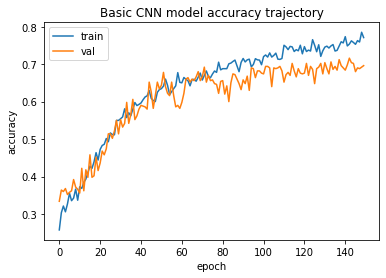

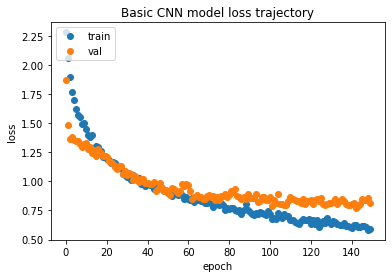

In [14]:
# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.7042889595031738


Fix model - CNN:

    No preprocessing: 0.6704

    Tommoy's: 0.7246

    Sliding: 0.7354 (50 epoch, less will be better)
    
    WPD: 0.7043


Fix preprocessing - no preprocessing:
    
    CNN: 0.6704
    CNN+LSTM: 0.6185 (150 epoch, less will be better)